We processed a large cache of UK governmental webpages from Common Crawl to analyze the policy focus of London local authorities. First, we filtered the dataset to retain only URLs belonging to London councils and containing policy-related keywords. To handle subdomains consistently, all URLs were mapped to a **uniform council name** (e.g., `education.hackney.gov.uk` and `hackney.gov.uk` both mapped to Hackney Council).

Next, we extracted textual content from these pages and applied **TF-IDF vectorization**, aggregating scores per council. This allowed us to identify both the **top recurring policy keywords** and the **distinct keywords unique to each council**.

We then categorized keywords into predefined policy areas (e.g., Housing & Planning, Transport & Infrastructure, Education & Skills) to produce a **structured overview of policy priorities per council**. Finally, we visualized the results using heatmaps for overall category focus and horizontal stacked bar charts to highlight the distribution of distinct policy keywords per council.

This pipeline ensures a **consistent, aggregated view of policy areas across all London councils**, accounting for subdomains and providing insights into both shared and unique local authority priorities.


In [ ]:
import duckdb
import json

# --- Step 0: Path to CSV dataset ---
csv_path = '/content/drive/MyDrive/UKWA/Datathon/problem4_govuk_split*.csv'

# --- Step 1: Define London Council domains and mapping to uniform council names ---
council_mapping = {
    "camden.gov.uk": "Camden Council",
    "greenwich.gov.uk": "Greenwich Council",
    "hackney.gov.uk": "Hackney Council",
    "hammersmithfulham.gov.uk": "Hammersmith & Fulham Council",
    "haringey.gov.uk": "Haringey Council",
    "harrow.gov.uk": "Harrow Council",
    "havering.gov.uk": "Havering Council",
    "hillingdon.gov.uk": "Hillingdon Council",
    "hounslow.gov.uk": "Hounslow Council",
    "islington.gov.uk": "Islington Council",
    "kensington.gov.uk": "Kensington & Chelsea Council",
    "kingston.gov.uk": "Kingston Council",
    "lambeth.gov.uk": "Lambeth Council",
    "lewisham.gov.uk": "Lewisham Council",
    "merton.gov.uk": "Merton Council",
    "newham.gov.uk": "Newham Council",
    "redbridge.gov.uk": "Redbridge Council",
    "richmond.gov.uk": "Richmond Council",
    "southwark.gov.uk": "Southwark Council",
    "sutton.gov.uk": "Sutton Council",
    "towerhamlets.gov.uk": "Tower Hamlets Council",
    "walthamforest.gov.uk": "Waltham Forest Council",
    "wandsworth.gov.uk": "Wandsworth Council",
    "westminster.gov.uk": "Westminster Council",
    "barkingdagenham.gov.uk": "Barking & Dagenham Council",
    "barnet.gov.uk": "Barnet Council",
    "brent.gov.uk": "Brent Council",
    "bromley.gov.uk": "Bromley Council",
    "ealing.gov.uk": "Ealing Council",
    "enfield.gov.uk": "Enfield Council",
    "cityoflondon.gov.uk": "City of London Corporation"
}

# --- Step 2: Define policy keywords in URLs ---
#policy_keywords = ["policy", "strategy", "plan", "consultation", "publication"]

# --- Step 3: Construct SQL filters ---
domain_filter = " OR ".join([f"url LIKE '%{d}%'" for d in council_mapping.keys()])
#policy_filter = " OR ".join([f"url LIKE '%{kw}%'" for kw in policy_keywords])

query = f"""
SELECT url, content
FROM read_csv_auto('{csv_path}', ignore_errors=True)
WHERE ({domain_filter}) AND ({policy_filter})
"""

# --- Step 4: Execute query ---
govuk_london = duckdb.query(query).to_df()

# --- Step 5: Map URLs to uniform council names ---
def get_council(url):
    for key, name in council_mapping.items():
        if key in url:
            return name
    return None

govuk_london['council'] = govuk_london['url'].apply(get_council)

# --- Step 6: Save results as JSONL ---
output_file = "/content/drive/MyDrive/UKWA/london_la_policy_pages_normalized.jsonl"
with open(output_file, "w", encoding="utf-8") as out_f:
    for _, row in govuk_london.iterrows():
        out_f.write(json.dumps({
            "url": row['url'],
            "council": row['council'],
            "text": row.get('content', "")
        }) + "\n")

print(f"Extraction completed. All subdomains mapped to uniform councils. Output saved to {output_file}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Extraction completed. All subdomains mapped to uniform councils. Output saved to /content/drive/MyDrive/UKWA/london_la_policy_pages_normalized.jsonl


In [ ]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Step 1: Load JSONL with normalized councils ---
jsonl_file = "/content/drive/MyDrive/UKWA/london_la_policy_pages_normalized.jsonl"
pages = []
with open(jsonl_file, "r", encoding="utf-8") as f:
    for line in f:
        pages.append(json.loads(line))

df = pd.DataFrame(pages)

# Ensure council column exists
if 'council' not in df.columns:
    raise ValueError("No 'council' field found in JSONL. Make sure URLs were normalized.")

# --- Step 2: Preprocess text ---
df['text_clean'] = df['text'].str.lower() \
    .str.replace(r'[^a-z0-9\s]', ' ', regex=True) \
    .str.replace(r'\s+', ' ', regex=True)

# --- Step 3: TF-IDF per council ---
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['text_clean'])
terms = vectorizer.get_feature_names_out()

# Aggregate TF-IDF by council
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df['council'] = df['council']
council_tfidf = tfidf_df.groupby('council').mean()

# --- Step 4: Identify top policy keywords per council ---
top_keywords = {}
for council in council_tfidf.index:
    top_terms = council_tfidf.loc[council].sort_values(ascending=False).head(15).index.tolist()
    top_keywords[council] = top_terms

# --- Step 5: Identify distinct policies ---
distinct_keywords = {}
for council in council_tfidf.index:
    other_mean = council_tfidf.drop(council).mean()
    diff = council_tfidf.loc[council] - other_mean
    distinct = diff.sort_values(ascending=False).head(10).index.tolist()
    distinct_keywords[council] = distinct

# --- Step 6: Save results ---
output = {'top_keywords': top_keywords, 'distinct_keywords': distinct_keywords}
output_file = "/content/drive/MyDrive/UKWA/london_la_policy_topics_normalized.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(output, f, indent=2)

In [ ]:
import json
import pandas as pd

# --- Load normalized TF-IDF results ---
topics_file = "/content/drive/MyDrive/UKWA/london_la_policy_topics_normalized.json"
with open(topics_file, "r", encoding="utf-8") as f:
    topics = json.load(f)

top_keywords = topics['top_keywords']
distinct_keywords = topics['distinct_keywords']

# --- Define policy categories ---
policy_categories = {
    "Housing & Planning": ["housing", "planning", "development", "landlord", "tenants", "homeless"],
    "Transport & Infrastructure": ["transport", "roads", "bus", "cycle", "traffic", "parking", "infrastructure"],
    "Environment & Climate": ["climate", "environment", "sustainability", "recycling", "carbon", "green"],
    "Education & Skills": ["school", "education", "college", "skills", "students", "learning"],
    "Social Care & Health": ["social care", "health", "care", "mental", "wellbeing", "support"],
    "Economy & Employment": ["business", "economy", "jobs", "employment", "investment"],
    "Community & Safety": ["community", "safety", "crime", "police", "emergency", "public"],
}

# --- Map keywords to categories ---
def map_to_categories(keywords):
    categories = set()
    for kw in keywords:
        for cat, kw_list in policy_categories.items():
            if any(k in kw for k in kw_list):
                categories.add(cat)
    return list(categories)

# --- Aggregate results per council ---
structured_results = {}
for council in top_keywords:
    structured_results[council] = {
        "top_categories": map_to_categories(top_keywords[council]),
        "distinct_keywords": distinct_keywords.get(council, [])
    }

# --- Save structured overview ---
output_file = "/content/drive/MyDrive/UKWA/london_la_policy_structured_normalized.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(structured_results, f, indent=2)

print("Structured policy overview saved for all London councils (normalized).")


Structured policy overview saved for all London councils (normalized).


#What this does

Rows: each London council

Columns: policy categories

Cell = 1 if council emphasizes that category (from top keywords)

Heatmap highlights overlaps and shows which councils have unique combinations of policy areas.

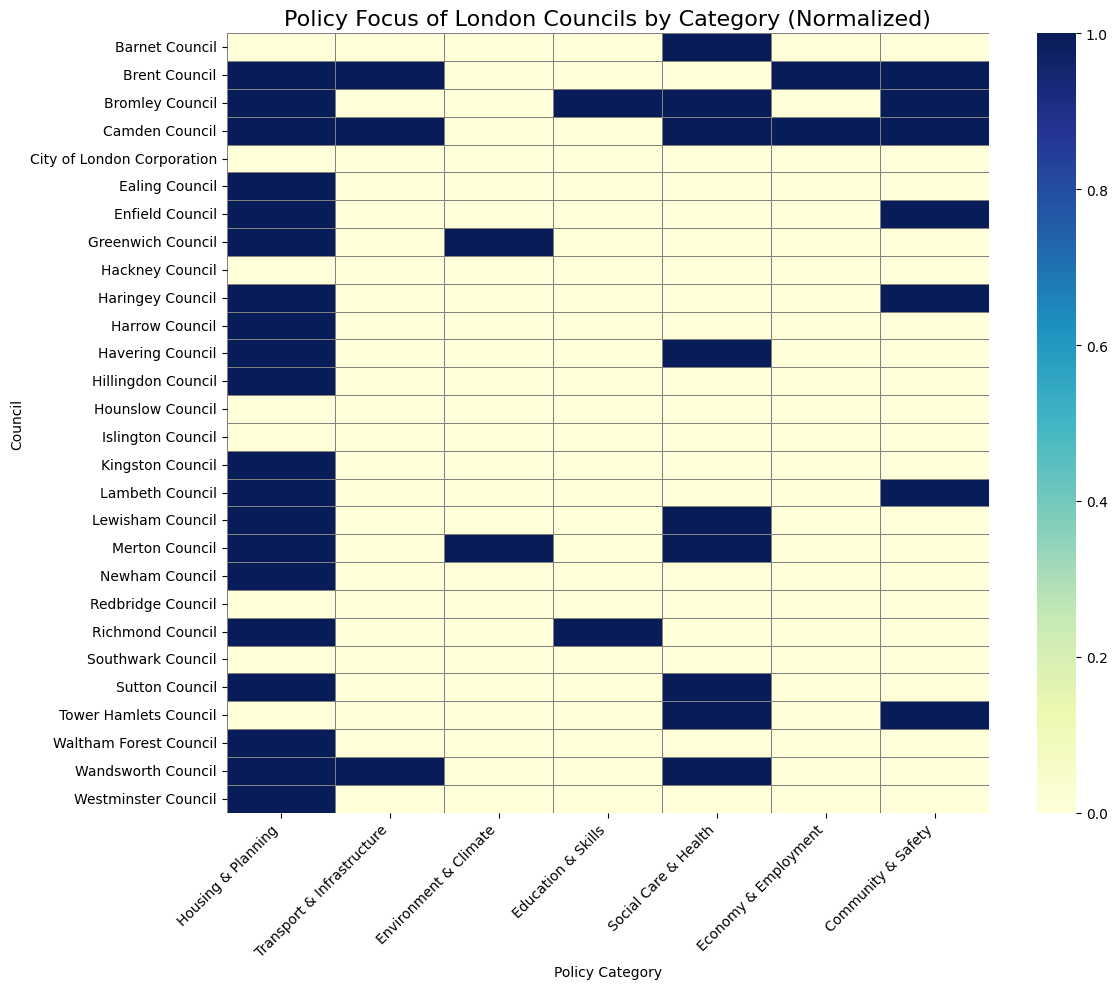

In [ ]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load structured policy data (normalized councils) ---
structured_file = "/content/drive/MyDrive/UKWA/london_la_policy_structured_normalized.json"
with open(structured_file, "r", encoding="utf-8") as f:
    structured = json.load(f)

# --- Define categories ---
categories = ["Housing & Planning", "Transport & Infrastructure", "Environment & Climate",
              "Education & Skills", "Social Care & Health", "Economy & Employment",
              "Community & Safety"]

# --- Prepare dataframe for heatmap ---
data = []
for council, info in structured.items():
    row = [1 if cat in info['top_categories'] else 0 for cat in categories]
    data.append([council] + row)

df = pd.DataFrame(data, columns=["Council"] + categories)
df = df.set_index("Council")

# --- Plot heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(df, cmap="YlGnBu", cbar=True, linewidths=0.5, linecolor='gray', annot=False)
plt.title("Policy Focus of London Councils by Category (Normalized)", fontsize=16)
plt.ylabel("Council")
plt.xlabel("Policy Category")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#What this shows

Councils with more distinct keywords stand out.

Stacked bars indicate the distribution of unique initiatives across policy areas.

Easy to compare councils and see where they focus uniquely.

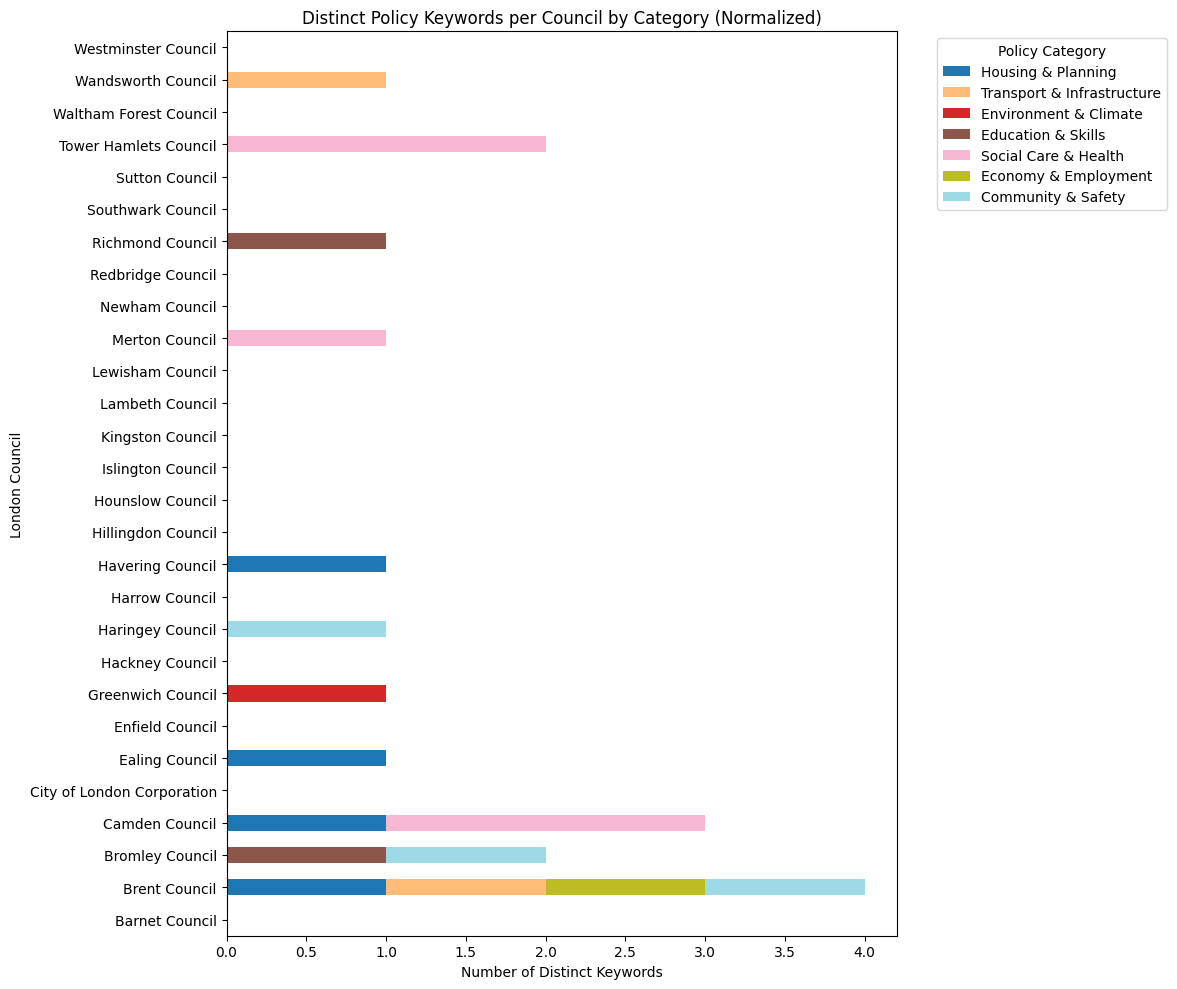

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# --- Load structured policy data (normalized councils) ---
structured_file = "/content/drive/MyDrive/UKWA/london_la_policy_structured_normalized.json"

try:
    with open(structured_file, "r", encoding="utf-8") as f:
        structured = json.load(f)
except FileNotFoundError:
    raise FileNotFoundError(f"Structured policy file not found at {structured_file}. Make sure the previous step ran successfully.")

# --- Define policy categories for mapping ---
policy_categories = {
    "Housing & Planning": ["housing", "planning", "development", "landlord", "tenants", "homeless"],
    "Transport & Infrastructure": ["transport", "roads", "bus", "cycle", "traffic", "parking", "infrastructure"],
    "Environment & Climate": ["climate", "environment", "sustainability", "recycling", "carbon", "green"],
    "Education & Skills": ["school", "education", "college", "skills", "students", "learning"],
    "Social Care & Health": ["social care", "health", "care", "mental", "wellbeing", "support"],
    "Economy & Employment": ["business", "economy", "jobs", "employment", "investment"],
    "Community & Safety": ["community", "safety", "crime", "police", "emergency", "public"],
}

# --- Prepare data for horizontal stacked bar chart ---
categories = list(policy_categories.keys())
data = []
for council, info in structured.items():
    row = {"Council": council}
    for cat in categories:
        count = sum(1 for kw in info['distinct_keywords'] if any(k in kw for k in policy_categories[cat]))
        row[cat] = count
    data.append(row)

df = pd.DataFrame(data).set_index("Council")

# --- Plot horizontal stacked bar chart ---
df.sort_index(inplace=True)
ax = df.plot(kind="barh", stacked=True, figsize=(12, 10), colormap='tab20')
plt.xlabel("Number of Distinct Keywords")
plt.ylabel("London Council")
plt.title("Distinct Policy Keywords per Council by Category (Normalized)")
plt.legend(title="Policy Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()